In [1]:
# importing the necessary modules
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import numpy as np
from sklearn import linear_model
from matplotlib import pyplot as plt
import seaborn as sns

## Product relationships and propensity to purchase

The questions to answer with this data are:
- What product category leads to the highest spend on the return purchases?
- What product category leads to the fastest return to purchase?
- What are the chances that they return to purchase the same item?
- If a customer purchases X product category first, what are they likely to buy next and when?
- If a customer doesn’t repurchase again within ‘X’ amount of time, they are unlikely to purchase again for X (by product category)

#### From meeting on 06/02/23

Points from the call:
- Start by looking at the relationship of best sellers to the rest of the products $\checkmark$
- Focus on Accessories and scooters and ignore the rest, at least for now $\checkmark$
- Find the 5 best sellers out of them and use them as the starting point for probability of subsequent purchases
- Look at relationship of scooter to scooter, accessory to accessory, accessory to scooter and scooter to accessory
- Look into normal distribution and standard deviation 



In [2]:
# Importing the data from the .xlsx as a data frame using the pandas module
df = pd.read_excel("productRelationships.xlsx", sheet_name = 'Data')

# getting rid of the Clinet_ID column
df = df.drop(columns = "Client_Id")

# renaming the headings to make it easier to reference them in the script
df.rename(columns = {'Repurchase_Period':'period','First_Product_Category':'first','Subsequent_Product_Category':'subs','Subsequent_Items_Ordered':'subsqty','Subsequent_Net_Value_before_Returns':'subsnet'},inplace=True)
df.head()

,period,first,subs,subsqty,subsnet
0,00 - 06 Month,ACC BAG,ACC BOTTLE,3,22.38
1,00 - 06 Month,ACC BAG,ACC NOISE MAKER,1,9.13
2,00 - 06 Month,ACC BASKET,SCOOTER ELECTRIC,1,416.63
3,00 - 06 Month,ACC BELL,SPARES CLAMPS,2,14.92
4,00 - 06 Month,ACC BELL,SPARES WHEELS,13,161.61


#### Finding the best sellers
Some filtering has to be done shown in the next cell.

First, the dataset will be reduced to only show the rows refering to scooters and accessories based on the conversation in the call. Also removing any that have 'X CHILLI' in as we mentioned that on the call as well.

I will also create a subset for just scooters and just accessories

In [101]:
# Finding all lines that include accessory or scooter in the first purchase column

acc_or_scoot_1 = df['first'].str.contains('|'.join(['ACC ', 'SCOOTER']))

# all locations that dont have xchilli
not_xchilli = ~df['first'].str.contains('X CHILLI') & ~df['subs'].str.contains('X CHILLI')

# those in subsequent purchase column
acc_or_scoot_2 = df['subs'].str.contains('|'.join(['ACC ', 'SCOOTER']))

# d1 includes all accessories and scooters
d1 = df.loc[acc_or_scoot_1 & acc_or_scoot_2 & not_xchilli]

# acc_only will only include accessories
acc_only = df.loc[df['first'].str.contains('ACC') & df['subs'].str.contains('ACC')]

# scoot_only will only include scooters
# Finding all locations where first purchase and subsequent purchase is Scooter
scoot = df['first'].str.contains('SCOOTER') & df['subs'].str.contains('SCOOTER')
scoot_only = df.loc[scoot & not_xchilli]

,period,first,subs,subsqty,subsnet
0,00 - 06 Month,ACC BAG,ACC BOTTLE,3,22.38
1,00 - 06 Month,ACC BAG,ACC NOISE MAKER,1,9.13
2,00 - 06 Month,ACC BASKET,SCOOTER ELECTRIC,1,416.63
5,00 - 06 Month,ACC BOTTLE,ACC BAG,38,364.86
6,00 - 06 Month,ACC BOTTLE HOLDER,ACC BAG,74,689.11
...,...,...,...,...,...
13086,55 - 60 Month,SCOOTER CYO,ACC PULL AND CARRY,1,5.97
13088,55 - 60 Month,SCOOTER MINI,ACC SCOOTER PEG,1,9.13
13089,55 - 60 Month,SCOOTER MINI,SCOOTER ADULT,12,1535.18
13092,55 - 60 Month,SCOOTER SPRITE,ACC WINDMILL,1,4.96


Working out which products out of the accessories and scooters are most popular. Below shows the top 5 best sellers on the first purchase along with the amount of customers that bought each in the dataframe

In [4]:
# barsize will control the size of the bar charts below. (x inches, y inches)
barsize = (12,3)
print("Category\tQTY of Customers")
top = d1['first'].value_counts().head(5)
top

Category	QTY of Customers


SCOOTER MINI      329
SCOOTER MAXI      313
SCOOTER 3 IN 1    298
SCOOTER SPRITE    286
ACC HELMET        282
Name: first, dtype: int64

I am going to create a list with the names of the top 5 products to make it easier to call them rather than having to write them out. This is done in cell 5

In [5]:
#names now holds the names in the list above
names = top.index.tolist()

From here, I will see what a bar chart looks like for each of these categories mapped onto the rest of the accessories and scooters.

Cell 6 below is a function to display the barchart by just entering the name of the category as seen in cell 7. 

In [6]:
#barchart function, just enter any category from scooter or accessory
def bestsellbar(name, barsize=(12,5)):
    d_product = d1.loc[d1['first'].str.contains(name)]
    d_product['subs'].value_counts(normalize=True).mul(100).plot(kind='bar',figsize=barsize)
    plt.title('Chart to show percetage of customers to subseqently buy each category after purchasing %s\n'%name)
    plt.xlabel('Category')
    plt.locator_params(axis='y',nbins=40)
    plt.ylabel('Percentage of customers [%]')

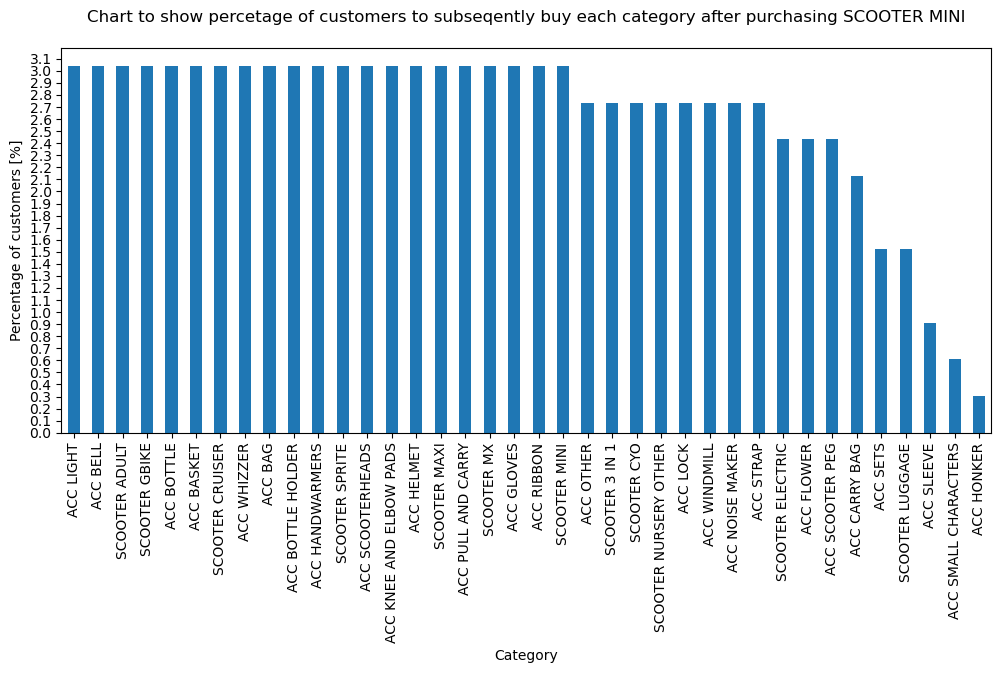

In [7]:
#names[0] is the first item in the list which is SCOOTER MAXI
bestsellbar(names[0])

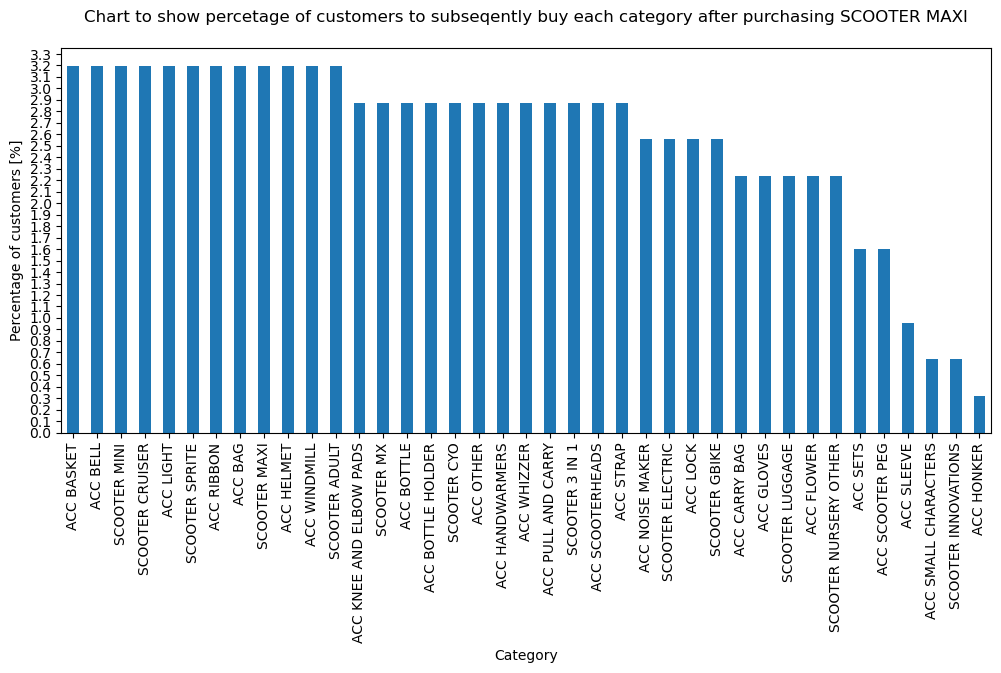

In [8]:
# names[1] contains the category SCOOTER MAXI
bestsellbar(names[1])

I've only plotted the top 2 to minimize clutter. Looking at these charts, you can clearly see the most popular categories to purchase subsequently however, I think its more important to see the relationship between the subsequent purchases between each top first purchase. Below is the above bar charts represented as tables which don't really help but may be useful to see as values.

In [9]:
def topsubs(name):
    d_product = d1.loc[d1['first'].str.contains(name)]
    print('Subsequent to %s' % name)
    print(' ')
    print(d_product['subs'].value_counts().head(10))
    print("There are %.0f customers that bought a %s" % (len(d_product),name))
    print('-------------------')
    return d_product['subs'].value_counts().head(10)

for name in names:
    topsubs(name)

Subsequent to SCOOTER MINI
 
ACC LIGHT            10
ACC BELL             10
SCOOTER ADULT        10
SCOOTER GBIKE        10
ACC BOTTLE           10
ACC BASKET           10
SCOOTER CRUISER      10
ACC WHIZZER          10
ACC BAG              10
ACC BOTTLE HOLDER    10
Name: subs, dtype: int64
There are 329 customers that bought a SCOOTER MINI
-------------------
Subsequent to SCOOTER MAXI
 
ACC BASKET         10
ACC BELL           10
SCOOTER MINI       10
SCOOTER CRUISER    10
ACC LIGHT          10
SCOOTER SPRITE     10
ACC RIBBON         10
ACC BAG            10
SCOOTER MAXI       10
ACC HELMET         10
Name: subs, dtype: int64
There are 313 customers that bought a SCOOTER MAXI
-------------------
Subsequent to SCOOTER 3 IN 1
 
ACC RIBBON          10
SCOOTER MAXI        10
SCOOTER CRUISER     10
ACC BAG             10
SCOOTER 3 IN 1      10
ACC LIGHT           10
SCOOTER ADULT       10
ACC SCOOTERHEADS    10
ACC BASKET          10
ACC BELL            10
Name: subs, dtype: int64
Ther

I'm going to create a function to plot all the charts in one as it will probably give us more information about the relationship between them.

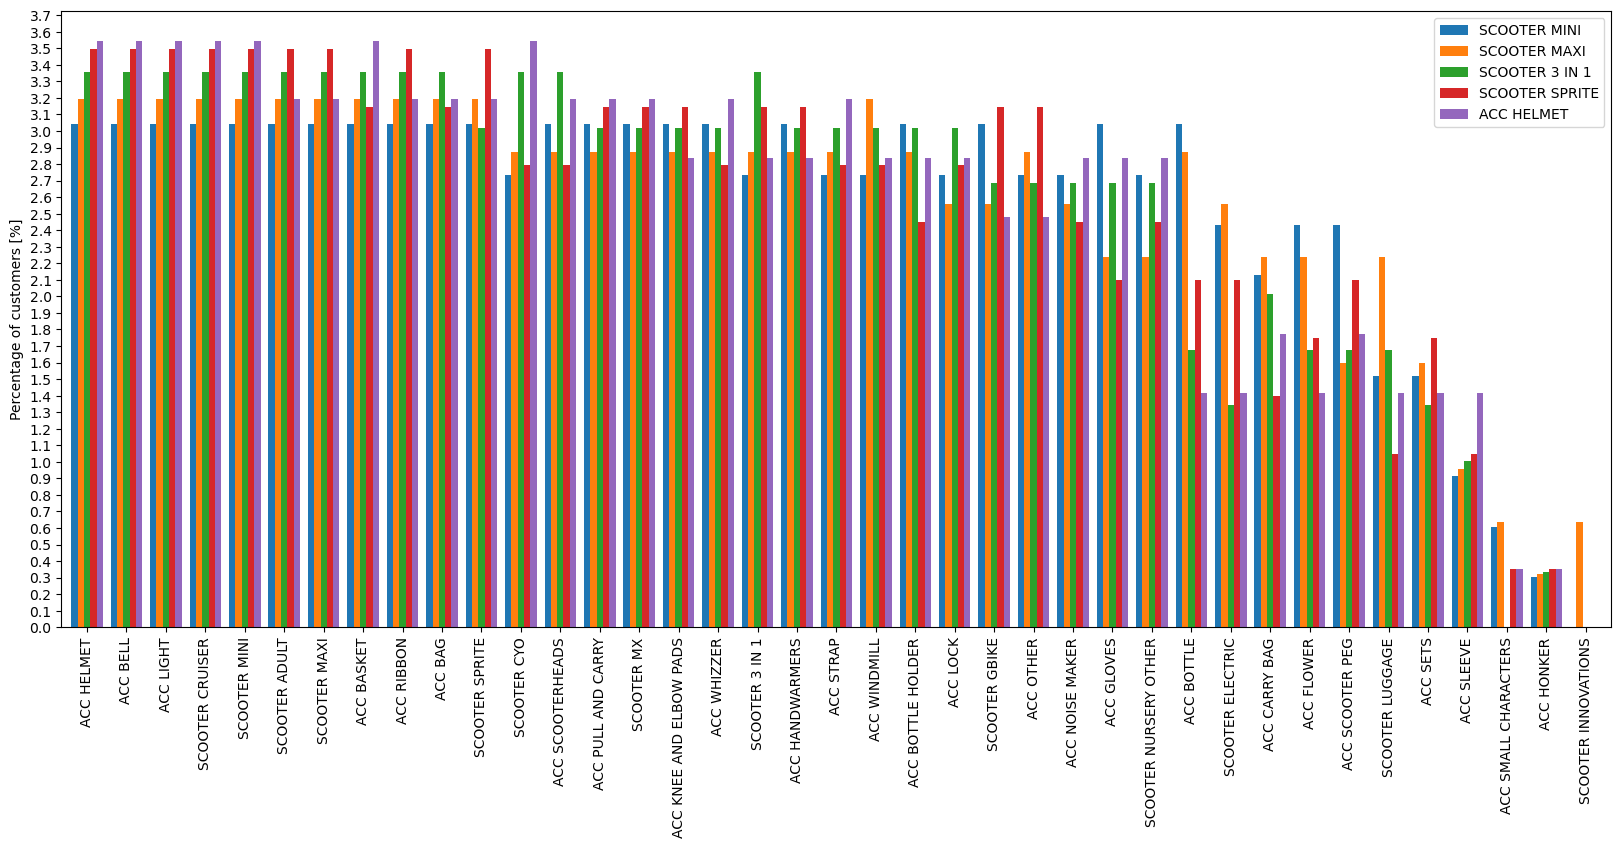

In [10]:
#barchart function, just enter any category from scooter or accessory
def bestsellbarmult(names, barsize=(20,8)):
    d_product = []

    
    index = d1.loc[d1['first'].str.contains('|'.join(names))]
    index = index['subs'].value_counts().index
    df = pd.DataFrame(index = index)
    
    for i in range(len(names)):
        d_product = d1.loc[d1['first'].str.contains(names[i])]
        d_product = d_product['subs'].value_counts(normalize=True).mul(100)
        df[names[i]] = d_product
    ax = df.plot.bar(rot=90,figsize = barsize, width=0.8)
    plt.locator_params(axis='y',nbins=40)
    ax.set_ylabel("Percentage of customers [%]")

bestsellbarmult(names)

The percentages for each bar are the percentage of customers that bought that category after buying a certain first category. So interestingly enough, the highest probability of returning to buy a helmet, is if you have bought a helmet the first time. I need to make sure that the logic is sound here but I think that this plot can be interpreted in this way. But then, if this is only data for those customers who returned to purchase, there isn't a 3.5% chance that they will buy a helmet if they bought a helmet to begin with. There is a 3.5% chance that they will subsequently buy a helmet after first buying a helmet, as long as they intend to purchase another category.

To calculate the probability of buying a category after another, you would also require the data for customers that did not return to purchase again.

Note: The barchart is naturally in the order of SCOOTER MAXI as that is the first name, I've changed it to be in the order of total sum of subseqent purchases.

In [11]:
def bestselloverall(names, barsize=(12,3)):
    d_product = d1.loc[d1['first'].str.contains('|'.join(names))]
    #normalize=True divides all of the values by the sum of values
    d_product['subs'].value_counts(normalize=True).mul(100).plot(kind='bar', figsize=barsize)
    plt.ylabel("Percentage of customers [%]")
    plt.xlabel("Category")
    plt.title('Bar chart to show what customers are most likely to purchase subsequently to the %s\n' % names)
    plt.locator_params(axis='y', nbins=30)

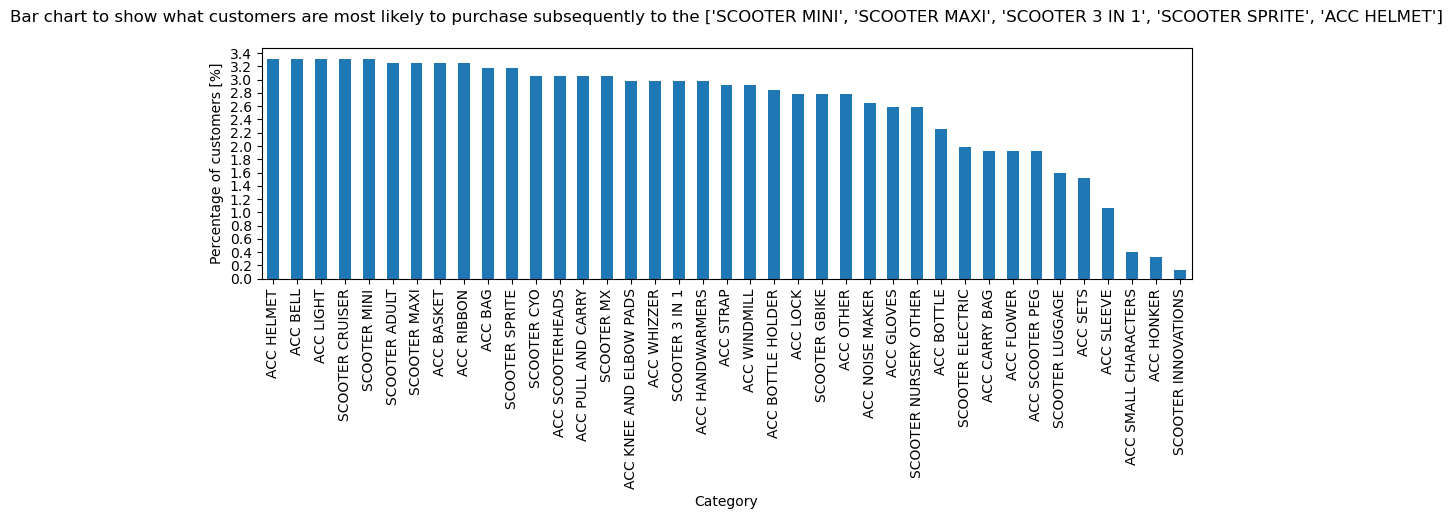

In [12]:
bestselloverall(names)

This chart shows the percentage of returning customers buying each item for all 5 top first categories combined. So if you bought any of the top 5, this is what percentage of those customers bought each subsequent category.

In [13]:
categories = ['SCOOTER MINI','SCOOTER MAXI','SCOOTER 3 IN 1','SCOOTER SPRITE','ACC HELMET']
d_product = d1.loc[d1['first'].str.contains('|'.join(categories))]
print('Subsequent to %s'%categories)
print(' ')
print(d_product['subs'].value_counts().head(10))

Subsequent to ['SCOOTER MINI', 'SCOOTER MAXI', 'SCOOTER 3 IN 1', 'SCOOTER SPRITE', 'ACC HELMET']
 
ACC HELMET         50
ACC BELL           50
ACC LIGHT          50
SCOOTER CRUISER    50
SCOOTER MINI       50
SCOOTER ADULT      49
SCOOTER MAXI       49
ACC BASKET         49
ACC RIBBON         49
ACC BAG            48
Name: subs, dtype: int64


### Looking at Accessories alone
Below are the best selling accessories. The function will show the most popular subsequent accessory purchases after buying a certain accessory. The function only requires the input of a category name.

In [14]:
acc_only['first'].value_counts().head(5)

ACC HELMET            186
ACC WHIZZER           152
ACC PULL AND CARRY    141
ACC RIBBON            139
ACC BELL              120
Name: first, dtype: int64

In [15]:
def bestsellbaracc(name, barsize=(12,3)):
    d_product = acc_only.loc[acc_only['first'].str.contains(name)]
    d_product['subs'].value_counts(normalize=True).mul(100).plot(kind='bar', figsize=barsize)
    plt.ylabel("Percentage of customers [%]")
    plt.xlabel("Category")
    plt.title('Bar chart to show what customers are most likely to purchase subsequently to the %s\n' % name)
    plt.locator_params(axis='y', nbins=20)

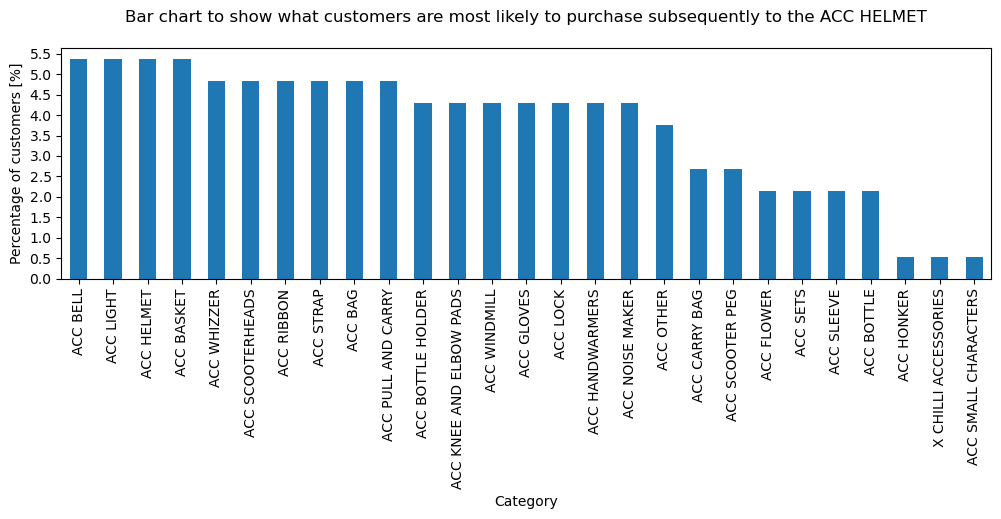

In [16]:
bestsellbaracc('ACC HELMET')

Okay, thats probably enough barcharts for now!

Lets look at Probability

### Standard Deviation and Normal Distribution

The scipy.stats function uses the following equation for the Normal Distribution:
$$f(x)=\frac{exp(-x^2/2)}{\sqrt{2 \pi}}$$

This normal distribution will require the mean value which the curve centres on and the standard deviation with equation:
$$\sigma=\sqrt{\frac{\Sigma(x_i-\mu)^2}{N}}$$

where:

$N$=population size

$x_i$=each value

$\mu$=population mean

By showing the value of the standard deviation before the normal distribution, we can compare the values and see the relationship of dispersion between the categories.

To begin with, the following table shows the most poular susequent purchases, these will then used to caluculate the normal distribution for the quantity ordered and the net value before returns.

In [43]:
barsize = (12,3)
print("Category\tQTY of customers")
top = d1['subs'].value_counts().head(5)
print(top)
#names now holds the names in the list above
names = top.index.tolist()

Category	QTY of customers
ACC HELMET        268
ACC BELL          263
SCOOTER MAXI      262
SCOOTER SPRITE    245
ACC LIGHT         245
Name: subs, dtype: int64


ACC HELMET has a standard deviation of 1214
ACC BELL has a standard deviation of 1010
SCOOTER MAXI has a standard deviation of 285
SCOOTER SPRITE has a standard deviation of 73
ACC LIGHT has a standard deviation of 457
----------------------------------------
ACC HELMET has a mean of 208
ACC BELL has a mean of 190
SCOOTER MAXI has a mean of 58
SCOOTER SPRITE has a mean of 25
ACC LIGHT has a mean of 92


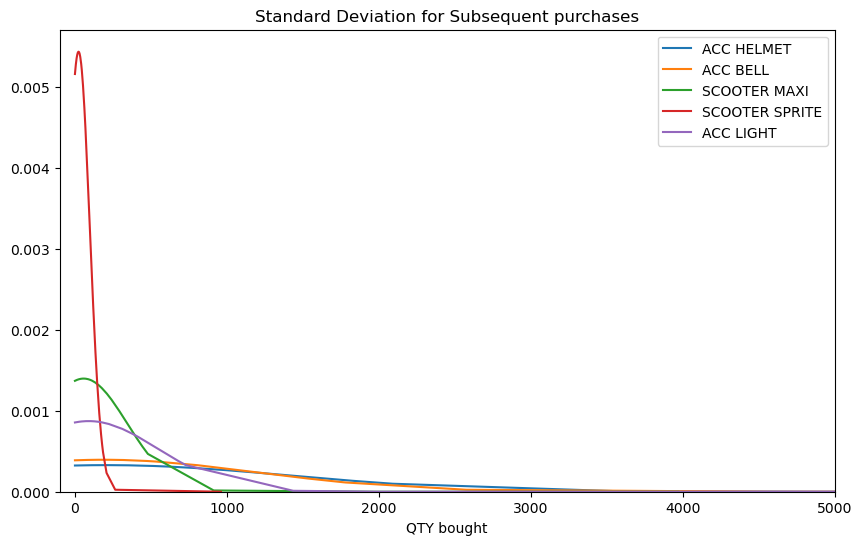

In [84]:
def subsqtydist(names):
    fig, ax = plt.subplots(figsize=(10,6))
    for name in names:
        lines = d1.loc[d1['subs'].str.contains(name)]
        values = lines['subsqty']
        values = values.sort_values(ascending=True)
        vals_mean = np.mean(values)
        vals_stddev = stats.tstd(values)
        nd = norm.pdf(values, vals_mean, vals_stddev)
        print("%s has a standard deviation of %.0f" % (name, vals_stddev))
        ax.plot(values, nd,label=name)
        
    print('----------------------------------------')
    for name in names:
        lines = d1.loc[d1['subs'].str.contains(name)]
        values = lines['subsqty']
        values = values.sort_values(ascending=True)
        vals_mean = np.mean(values)
        print("%s has a mean of %.0f" % (name, vals_mean))

    ax.set_title("Standard Deviation for Subsequent purchases")
    ax.set_xlabel("QTY bought")
    ax.set_xlim([-100,5000])
    ax.set_ylim(0)
    ax.legend()
    #return values

#names[0] will hold ACC HELMET
subsqtydist(names)

Looking at the plot above, the normal distribution of qty for the top 5 most popular categories to subsequently buy have been plotted. I don't think its very surprising that the scooters have the smallest standard deviation as logically, most customers will only want to buy 1. The Helmet has the largest standard deviation meaning there is a wider range of quantities that a customer is likely to buy.

The plot does not look like the classic bell curve that a normal distribution should have, this is just down to the fact that there is a lower limit of purchase qty amounts. You can't buy less than 1.

Next, the same will be plotted but for net value before returns.

ACC HELMET has a standard deviation of 33061
ACC BELL has a standard deviation of 5729
SCOOTER MAXI has a standard deviation of 28926
SCOOTER SPRITE has a standard deviation of 6302
ACC LIGHT has a standard deviation of 3009
------------------------------------------
ACC HELMET has a mean of 5703
ACC BELL has a mean of 1086
SCOOTER MAXI has a mean of 6040
SCOOTER SPRITE has a mean of 2140
ACC LIGHT has a mean of 608


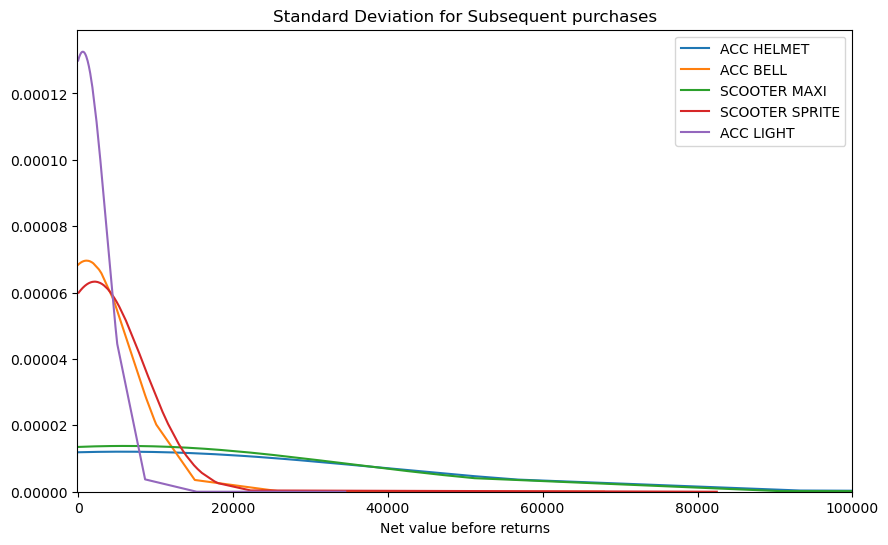

In [86]:
def subsvaldist(names):
    fig, ax = plt.subplots(figsize=(10,6))
    for name in names:
        lines = d1.loc[d1['subs'].str.contains(name)]
        values = lines['subsnet']
        values = values.sort_values(ascending=True)
        vals_mean = np.mean(values)
        vals_stddev = stats.tstd(values)
        nd = norm.pdf(values, vals_mean, vals_stddev)
        print("%s has a standard deviation of %.0f" % (name, vals_stddev))
        ax.plot(values, nd,label=name)
    print('------------------------------------------')
        
    for name in names:
        lines = d1.loc[d1['subs'].str.contains(name)]
        values = lines['subsnet']
        values = values.sort_values(ascending=True)
        vals_mean = np.mean(values)
        print("%s has a mean of %.0f" % (name, vals_mean))
    
    ax.set_title("Standard Deviation for Subsequent purchases")
    ax.set_xlabel("Net value before returns")
    ax.set_xlim([-100,100000])
    ax.set_ylim(0)
    ax.legend()

#names[0] will hold ACC HELMET
subsvaldist(names)

For net value, the light accessory seems to have the smallest standard deviation and also the smallest mean value.
Scooter Maxi has the highest mean net value before returns but one of the highest standard deviations meaning that there is much more of a spread of 

Now maybe it will be more useful to carry out normal distribution analysis between top scooter categories and top accessory categories seperately.

In [76]:
print("Category\tQTY of customers")
top_scoot = scoot_only['subs'].value_counts().head(5)
print(top_scoot)
#names now holds the names in the list above
names_scoot = top_scoot.index.tolist()

Category	QTY of customers
SCOOTER MAXI       112
SCOOTER ADULT      108
SCOOTER CRUISER    107
SCOOTER SPRITE     104
SCOOTER MINI       103
Name: subs, dtype: int64


SCOOTER MAXI has a standard distribution of 285
SCOOTER ADULT has a standard distribution of 132
SCOOTER CRUISER has a standard distribution of 60
SCOOTER SPRITE has a standard distribution of 73
SCOOTER MINI has a standard distribution of 132
----------------------------------------
SCOOTER MAXI has a mean of 58
SCOOTER ADULT has a mean of 35
SCOOTER CRUISER has a mean of 21
SCOOTER SPRITE has a mean of 25
SCOOTER MINI has a mean of 37


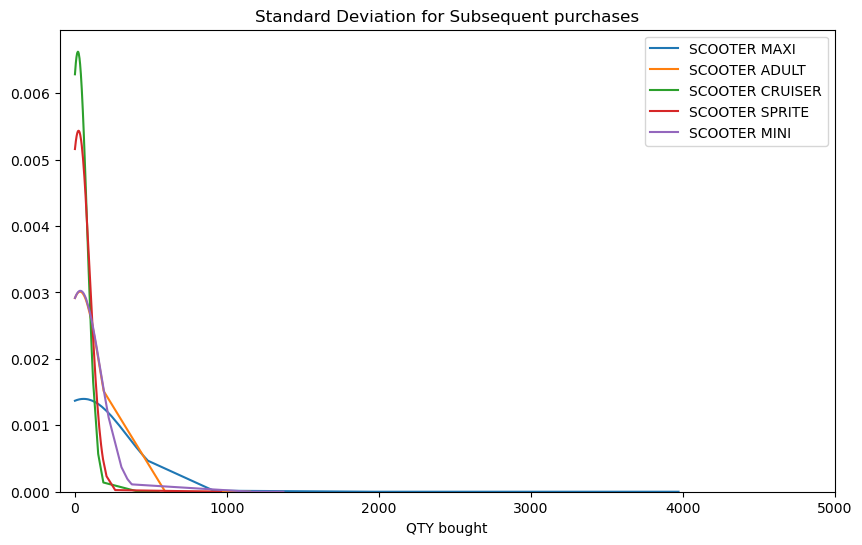

In [77]:
subsqtydist(names_scoot)

In [55]:
print("Category\tQTY of customers")
top_acc = acc_only['subs'].value_counts().head(5)
print(top_acc)
#names now holds the names in the list above
names_acc = top_acc.index.tolist()

Category	QTY of customers
ACC HELMET    166
ACC BELL      161
ACC LIGHT     146
ACC BASKET    126
ACC RIBBON    123
Name: subs, dtype: int64


ACC HELMET has a standard distribution of 1214
ACC BELL has a standard distribution of 1010
ACC LIGHT has a standard distribution of 457
ACC BASKET has a standard distribution of 286
ACC RIBBON has a standard distribution of 474
----------------------------------------
ACC HELMET has a mean of 208
ACC BELL has a mean of 190
ACC LIGHT has a mean of 92
ACC BASKET has a mean of 62
ACC RIBBON has a mean of 83


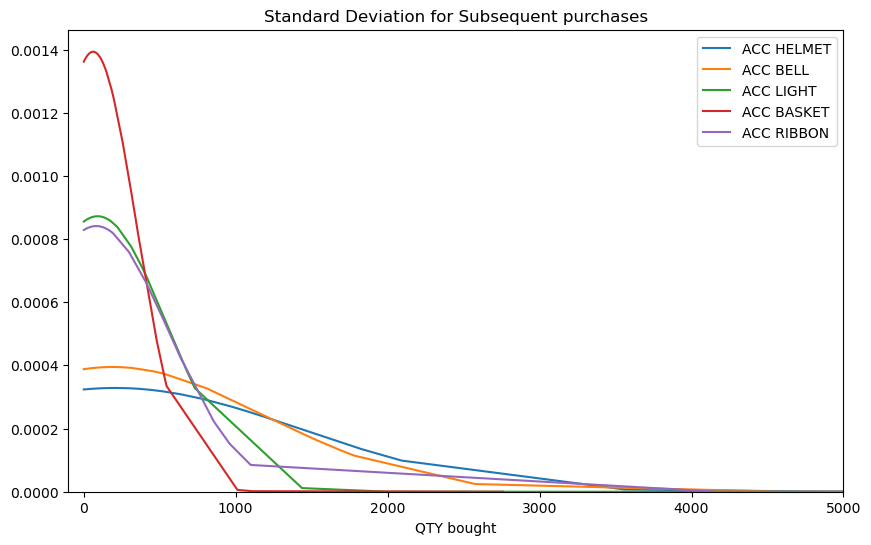

In [78]:
subsqtydist(names_acc)

As seen, by separating the accessories from the scooters, the normal distributions match each other better.
The scooters have a smaller standard deviation and a smaller mean between them meaning that people buy less quantity of the scooters and the qunatity they buy is more easily predicted.

### Looking into probability
Conditional probability is the probability of picking an item given that a certain item has been picked which is what is wanted here.

$$P(B|A) = \frac{P(A \cap B)}{P(A)}$$

In this case, the events are independant (The second event is not influenced by the first event)

$$P(A \cap B) = P(A)xP(B)$$


So, to start with the top seller and the most subseqently bought item. Lets start with:
What is the probability of buying an accessory light after first purchasing a Scooter MINI

In [100]:
print("%.1f%% of customers bought an accessory" % (len(acc_only)/len(d1)*100))
print("%.1f%% of customers bought an scooter" % (len(scoot_only)/len(d1)*100))

34.1% of customers bought an accessory
20.6% of customers bought an scooter


Above, I have literally just divided the number of customers that bought an accessory by the total amount of customers that bought a scooter or an accessory. This is not probability.

In [125]:
scoot_only['first'].value_counts(normalize=True).sort_values(ascending=True)

SCOOTER INNOVATIONS      0.002566
ACC SCOOTER PEG          0.012831
SCOOTER ELECTRIC         0.027374
SCOOTER LUGGAGE          0.041061
ACC SCOOTERHEADS         0.043627
SCOOTER NURSERY OTHER    0.058169
SCOOTER CRUISER          0.067579
SCOOTER GBIKE            0.073567
SCOOTER MX               0.076133
SCOOTER ADULT            0.088109
SCOOTER CYO              0.094953
SCOOTER SPRITE           0.098375
SCOOTER 3 IN 1           0.100941
SCOOTER MAXI             0.105218
SCOOTER MINI             0.109495
Name: first, dtype: float64

In [118]:
d1['first'].value_counts(normalize=True).mul(100).sort_values().head()

SCOOTER INNOVATIONS     0.070398
ACC SMALL CHARACTERS    0.123196
ACC BOTTLE              0.510384
ACC FLOWER              0.527983
ACC CARRY BAG           0.774375
Name: first, dtype: float64

In [119]:
d1['subs'].value_counts(normalize=True).mul(100).sort_values(ascending=True).head()

SCOOTER INNOVATIONS     0.087997
ACC SMALL CHARACTERS    0.175994
ACC HONKER              0.351989
ACC SLEEVE              0.809574
SCOOTER LUGGAGE         0.915171
Name: subs, dtype: float64

Text(0.5, 1.0, 'Time from first to subsequent purchase')

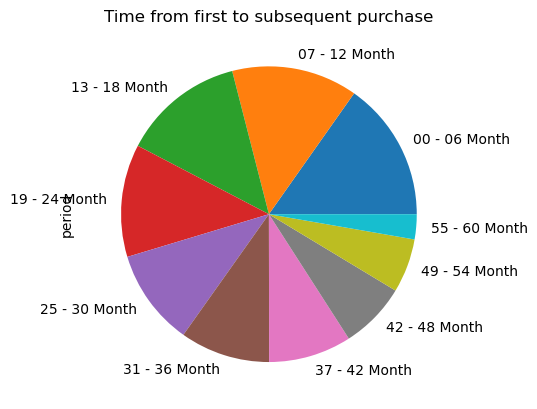

In [102]:
scoot_only['period'].value_counts().plot(kind='pie')
plt.title("Time from first to subsequent purchase")